In [0]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np

In [0]:
batch_size = 64
num_workers = 1

#define transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# load imagenet
image_dataset = {
        'train' :datasets.CIFAR10('./', train=True, download=True, transform=data_transforms['train']),
        'test' : datasets.CIFAR10('./', train=False, download=True, transform=data_transforms['train']) 
}

# Create the dataloaders
data_loader = {
    'train': torch.utils.data.DataLoader(image_dataset['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'test': torch.utils.data.DataLoader(image_dataset['test'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
}

0it [00:00, ?it/s]

170500096it [00:07, 23085143.21it/s]                               


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [0]:
!git clone https://github.com/jjmachan/DeepHash
!mv siamese-triplet triplet
import triplet.datasets

Cloning into 'siamese-triplet'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 146 (delta 0), reused 0 (delta 0), pack-reused 143
Receiving objects: 100% (146/146), 12.61 MiB | 32.12 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [0]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from triplet.trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


In [0]:
from torch.utils.data import Dataset
import numpy as np
from PIL import Image

class TripletCifar1(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, dataset):
        self.dataset = dataset
        self.train = self.dataset.train
        self.transform = self.dataset.transform

        if self.train:
            self.train_labels = np.array(self.dataset.targets,dtype=np.float32)
            self.train_data = self.dataset.data
            #self.train_data = self.train_data.reshape(-1, 3, 32, 32)
            #self.train_data = self.train_data.transpose((0, 2, 3, 1))  # convert to HWC
            self.labels_set = set(self.train_labels)
            self.label_to_indices = {label: np.where(self.train_labels == label)[0]
                                     for label in self.labels_set}
        else:
            self.test_labels = np.array(self.dataset.targets)
            self.test_data = self.dataset.data
            # generate fixed triplets for testing
            self.labels_set = set(self.test_labels)
            self.label_to_indices = {label: np.where(self.test_labels == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(9)

            triplets = [[i,
                         random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                         random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.test_labels[i].item()]))
                                                 )
                                             ])
                         ]
                        for i in range(len(self.test_data))]
            self.test_triplets = triplets

    def __getitem__(self, index):
        if self.train:
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            img2 = self.train_data[positive_index]
            img3 = self.train_data[negative_index]
        else:
            img1 = self.test_data[self.test_triplets[index][0]]
            img2 = self.test_data[self.test_triplets[index][1]]
            img3 = self.test_data[self.test_triplets[index][2]]

        img1 = Image.fromarray(img1)
        img2 = Image.fromarray(img2)
        img3 = Image.fromarray(img3)
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)
        return (img1, img2, img3), []

    def __len__(self):
        return len(self.dataset)

In [0]:
from torch.utils.data.sampler import BatchSampler

class BalancedBatchSampler1(BatchSampler):
    """
    BatchSampler - from a MNIST-like dataset, samples n_classes and within these classes samples n_samples.
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = np.array(labels, dtype=np.float32)
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(self.labels == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [0]:
# Set up data loaders
from triplet.datasets import BalancedBatchSampler

cuda = torch.cuda.is_available()
train_batch_sampler = BalancedBatchSampler1(image_dataset['train'].targets, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler1(image_dataset['test'].targets, n_classes=10, n_samples=25)


In [0]:
class BinaryLayer(nn.Module):
    def __init__(self):
        super(BinaryLayer, self).__init__()
        self.binaryLayer = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128,32)
        )
        
    def forward(self, x):
      return self.binaryLayer(x) 

In [0]:
# An identity layer to pass the fc layer in resnet
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
 
# Define model
resnet18  = models.resnet18(pretrained=True)
resnet18.fc = BinaryLayer()

# Freeze all the parameters in the model
def freeze_model(model):
  for params in model.parameters():
    params.requires_grad=False


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 72.9MB/s]


In [0]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(image_dataset['train'], batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(image_dataset['test'], batch_sampler=test_batch_sampler, **kwargs)

In [0]:
loader = iter(online_train_loader)
images, labels = next(loader)
print(images.shape)
out = model(images.cuda())
print(out)
print(torch.sign(out))

NameError: ignored

In [0]:
class OnlineBinaryTripletLoss(nn.Module):
    """
    Online Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, lam, triplet_selector):
        super(OnlineBinaryTripletLoss, self).__init__()
        self.lam = lam
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()
        a = embeddings[triplets[:, 0]].unsqueeze(-1)
        p = embeddings[triplets[:, 1]].unsqueeze(-2)
        n = embeddings[triplets[:, 2]].unsqueeze(-2)

        theta_ap = torch.bmm(p, a)/2
        theta_an = torch.bmm(n, a)/2

        b = torch.sign(embeddings)
        reg = (b-embeddings).pow(2).sum(1).sum()

        p = theta_ap - theta_an - self.margin 
        losses = -(p - torch.log(1 + torch.exp(p))).sum() +(self.lam*reg).sum()
        return losses, len(triplets)

In [0]:
a = torch.FloatTensor(4,1,32).uniform_(-1,1)
p = torch.FloatTensor(4,1,32).uniform_(-1,1)
n = torch.FloatTensor(4,1,32).uniform_(-1,1)

u = torch.FloatTensor(100, 32).uniform_(-1,1)
a.transpose_(2,1)
theta_ap = torch.bmm(p, a)/2
theta_an = torch.bmm(n, a)/2
print(theta_ap.shape)
alpha = 16
lamdha = 100

p = theta_ap - theta_an -alpha
loss = p - torch.log(1 + torch.exp(p))
loss.mean()

torch.Size([4, 1, 1])


tensor(-14.6922)

In [0]:
from itertools import combinations

def pdist(vectors):
  theta_dist = torch.mm(vectors, vectors.T)/2
  return theta_dist


class TripletSelector:
    """
    Implementation should return indices of anchors, positive and negative samples
    return np array of shape [N_triplets x 3]
    """

    def __init__(self):
        pass

    def get_triplets(self, embeddings, labels):
        raise NotImplementedError

class AllTripletSelector(TripletSelector):
    """
    Returns all possible triplets
    May be impractical in most cases
    """

    def __init__(self):
        super(AllTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs

            # Add all negatives for all positive pairs
            temp_triplets = [[anchor_positive[0], anchor_positive[1], neg_ind] for anchor_positive in anchor_positives
                             for neg_ind in negative_indices]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))


def hardest_negative(loss_values):
    hard_negative = np.argmax(loss_values)
    return hard_negative if loss_values[hard_negative] > 0 else None


def random_hard_negative(loss_values):
    hard_negatives = np.where(loss_values > 0)[0]
    return np.random.choice(hard_negatives) if len(hard_negatives) > 0 else None


def semihard_negative(loss_values, margin):
    semihard_negatives = np.where(np.logical_and(loss_values < margin, loss_values > 0))[0]
    return np.random.choice(semihard_negatives) if len(semihard_negatives) > 0 else None

class FunctionNegativeTripletSelector(TripletSelector):
    """
    For each positive pair, takes the hardest negative sample (with the greatest triplet loss value) to create a triplet
    Margin should match the margin used in triplet loss.
    negative_selection_fn should take array of loss_values for a given anchor-positive pair and all negative samples
    and return a negative index for that pair
    """

    def __init__(self, margin, negative_selection_fn, cpu=True):
        super(FunctionNegativeTripletSelector, self).__init__()
        self.cpu = cpu
        self.margin = margin
        self.negative_selection_fn = negative_selection_fn

    def get_triplets(self, embeddings, labels):
        if self.cpu:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []

        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)

            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] - self.margin
                loss_values = -(loss_values)
                loss_values = loss_values.data.cpu().numpy()
                hard_negative = self.negative_selection_fn(loss_values)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

        if len(triplets) == 0:
            triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])

        triplets = np.array(triplets)

        return torch.LongTensor(triplets)


def HardestNegativeTripletSelector1(margin, cpu=False): return FunctionNegativeTripletSelector(margin=margin,
                                                                                 negative_selection_fn=hardest_negative,
                                                                                 cpu=cpu)


def RandomNegativeTripletSelector1(margin, cpu=False): return FunctionNegativeTripletSelector(margin=margin,
                                                                                negative_selection_fn=random_hard_negative,
                                                                                cpu=cpu)


def SemihardNegativeTripletSelector1(margin, cpu=False): return FunctionNegativeTripletSelector(margin=margin,
                                                                                  negative_selection_fn=lambda x: semihard_negative(x, margin),
                                                                                  cpu=cpu)

In [0]:
# Set up the network and training parameters
from triplet.networks import EmbeddingNet
from triplet.losses import OnlineTripletLoss
from triplet.utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from triplet.metrics import AverageNonzeroTripletsMetric

margin = 16
embedding_net = resnet18
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineBinaryTripletLoss(margin, 0, RandomNegativeTripletSelector1(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 7, gamma=0.8, last_epoch=-1)
n_epochs = 15
log_interval = 15

In [0]:
loss_fn = OnlineBinaryTripletLoss(margin, 10, RandomNegativeTripletSelector1(margin))
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

Train: [0/50000 (0%)]	Loss: 284145.500000	Average nonzero triplets: 1582.0
Train: [3750/50000 (8%)]	Loss: 85692.217708	Average nonzero triplets: 2750.125
Train: [7500/50000 (15%)]	Loss: 48880.400260	Average nonzero triplets: 2776.483870967742
Train: [11250/50000 (22%)]	Loss: 35478.528646	Average nonzero triplets: 2793.1521739130435
Train: [15000/50000 (30%)]	Loss: 32577.138542	Average nonzero triplets: 2802.311475409836
Train: [18750/50000 (38%)]	Loss: 31958.411458	Average nonzero triplets: 2799.0526315789475
Train: [22500/50000 (45%)]	Loss: 29575.233724	Average nonzero triplets: 2780.3186813186812
Train: [26250/50000 (52%)]	Loss: 30778.987630	Average nonzero triplets: 2778.801886792453
Train: [30000/50000 (60%)]	Loss: 31252.439453	Average nonzero triplets: 2774.96694214876
Train: [33750/50000 (68%)]	Loss: 30223.067969	Average nonzero triplets: 2772.044117647059
Train: [37500/50000 (75%)]	Loss: 30537.585026	Average nonzero triplets: 2773.139072847682
Train: [41250/50000 (82%)]	Loss: 30

In [0]:
torch.save(model, './triplet_resnet18_epoche10_alpha16_lamdha0.mdl')

In [0]:
model = torch.load('./triplet_resnet18_epoche10_alpha16_lamdha0.mdl')

In [0]:
for i in range(10):
  print('Starting: ',i)
  fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])
  torch.save(model, './triplet_resnet18_binary%d.mdl'%(i))
  print("checkpoint saved")

In [0]:
torch.save(model, './triplet_vgg20_2.mdl')

In [0]:
# save to google drive 

from google.colab import drive
drive.mount('/gdrive')

!cp *.mdl /gdrive/My\ Drive/tooploox

In [0]:
# load data
from google.colab import drive
drive.mount('/gdrive')
!cp /gdrive/My\ Drive/tooploox/*.mdl ./ 

In [0]:
model_test = torch.load('./triplet_vgg19.mdl')
model.eval()

In [0]:
# Freeze all the parameters in the model
def freeze_model(model):
  for params in model.parameters():
    params.requires_grad=False

def unfreeze_model(model):
  for params in model.parameters():
    params.requires_grad= True

# check if all the parameters have been freezed
def list_trainable(model):
  for params in model.parameters():
    print(params.requires_grad)
  
# delete the last layers
def del_last_layers(model_class, num_layers):
  model_class = nn.Sequential(*list(model_class.children())[:-num_layers])
  return model_class

In [0]:
def create_embeddings(model, embedding_size):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print(device)
  model.eval()
  features = {}
  targets = {}
  model.to(device)
  features['train'] = np.empty([0, embedding_size])
  targets['train'] = np.empty([0, ])

  features['test'] = np.empty([0, embedding_size])
  targets['test'] = np.empty([0,])

  for i, (images,target) in enumerate(data_loader['train']):
    images = images.to(device)
    target = target.to(device)

    try:
      output = model(images).cpu().detach().numpy()
      features['train'] = np.append(features['train'],output, axis=0)
      targets['train'] = np.append(targets['train'],target.cpu(), axis=0)
    except:
      print(output.shape)
      print('error occured: ', e)
      return (None, None)
    
    if i%100 == 0:
      print(i)

  for i, (images,target) in enumerate(data_loader['test']):
    images = images.to(device)
    target = target.to(device)

    output = model(images).cpu().detach().numpy()
    features['test'] = np.append(features['test'],output, axis=0)
    targets['test'] = np.append(targets['test'],target.cpu(), axis=0)

    if i%100 == 0:
      print(i)
  return (features, targets)

In [0]:
features, targets = create_embeddings(model, 32)

cuda
0
100
200
300
400
500
600
700
0
100


In [0]:
features['train'].shape

(50000, 32)

In [0]:
model.fc = Identity()

In [0]:
model_emb = model
freeze_model(model_emb)
print(model_emb)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# Save and load
import pickle

def save(features, targets, model_name):
  with open(model_name+'.embs', 'wb') as file:
    pickle.dump((features,targets), file)
    print('file saved in ', model_name)

def load(model_name):
  with open(model_name+'.embs', 'rb') as file:
    features, targets = pickle.load(file)
    return (features, targets)


In [0]:
# save the computed embeddings
save(features_sign, targets, 'binary_epoch15_alpha16_sign')

file saved in  binary_epoch15_alpha16_sign


In [0]:
# save to google drive 

from google.colab import drive
drive.mount('/gdrive')

!cp *embs /gdrive/My\ Drive/tooploox

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
!ls /gdrive/My\ Drive/tooploox

In [0]:
features_sign = {}
features_sign['train'] = np.sign(features['train'])
features_sign['test'] = np.sign(features['test'])
features_sign['test'][0]

array([ 1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.,
       -1., -1., -1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,
       -1.,  1., -1.,  1.,  1., -1.])

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

k_range = range(25,30)

def search_knn_accuracies(k_range, features, targets):
  acc = []
  for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(features['train'], targets['train'])
    #print('finished fitting')
    predict = knn.predict(features['test'][:300,:])
    #print('predicted')
    score = metrics.accuracy_score(targets['test'][:300], predict)
    print('K value: %d, accuracy: %0.7f' %(k, score))
    acc.append(score)
  print('Mean accuracy ',sum(acc)/len(acc))

# the best score was obtained when k = 20:24
search_knn_accuracies(k_range, features, targets)

K value: 25, accuracy: 0.8100000
K value: 26, accuracy: 0.8033333
K value: 27, accuracy: 0.8100000
K value: 28, accuracy: 0.8133333
K value: 29, accuracy: 0.8133333
Mean accuracy  0.8099999999999999


In [0]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from sklearn.manifold import TSNE
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123
# need to create a subset of the data, too much time to process otherwise
x_subset = features['train'][:5000]
y_subset = targets['train'][:5000]

print(np.unique(y_subset))
labels = {
     0: 'airplane',  
     1: 'automobile',
     2: 'bird',
     3: 'cat',
     4: 'deer',
     5: 'dog',
     6: 'frog',
     7: 'horse',
     8: 'ship',
     9: 'truck',
}
# Utility function to visualize the outputs of PCA and t-SNE

def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(labels[i]), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [0]:
# do pca before passing to tsne to reduce noice and fast performance
time_start = time.time()

pca_50 = PCA(n_components=32)
pca_result_50 = pca_50.fit_transform(x_subset)

print('PCA with 50 components done! Time elapsed: {} seconds'.format(time.time()-time_start))

print('Cumulative variance explained by 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))
# perform tsne on 50 components
time_start = time.time()


fashion_pca_tsne = TSNE(random_state=RS).fit_transform(pca_result_50)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

PCA with 50 components done! Time elapsed: 0.013384819030761719 seconds
Cumulative variance explained by 50 principal components: 1.0
t-SNE done! Time elapsed: 37.46543502807617 seconds


(<Figure size 576x576 with 1 Axes>,
 [Text(-29.87027, -24.568775, 'airplane'),
  Text(-71.17509, -0.44621837, 'automobile'),
  Text(5.141738, -22.821735, 'bird'),
  Text(15.812429, 40.410366, 'cat'),
  Text(35.659733, -22.13056, 'deer'),
  Text(57.13344, -1.5746105, 'dog'),
  Text(-11.7645855, 40.210827, 'frog'),
  Text(45.08953, 21.392338, 'horse'),
  Text(-39.422935, 21.45201, 'ship'),
  Text(-2.4064803, -57.642292, 'truck')])

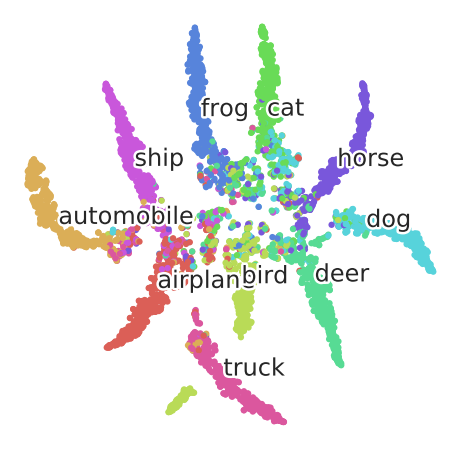

In [0]:
fashion_scatter(fashion_pca_tsne, y_subset)

In [0]:
def average_precision(vector):
  assert vector.ndim == 1
  sum_precision = 0
  num_true_values = 0
  for i, value in enumerate(vector):
    if value:
      num_true_values += 1
    sum_precision += value*num_true_values/(i+1)
  return sum_precision/(sum(vector)+ 0.00000001)
def mAP(features, targets):

  num_elements_to_retrieve = 50
  num_test_queries = 36

  knn = KNeighborsClassifier(n_neighbors=29)
  knn.fit(features['train'], targets['train'])
  indexes = knn.kneighbors(features['test'][:num_test_queries],num_elements_to_retrieve, return_distance=False)
  results = targets['train'][indexes] == targets['test'][:num_test_queries].reshape(-1, 1)
  APs = []
  for vector in results:
    APs.append(average_precision(vector))
  print('mAP is: ',sum(APs)/len(APs))
mAP(features, targets)

mAP is:  0.8600498241690964
